In [1]:
%matplotlib inline
import flopy
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import numpy as np
import pandas as pd
import pathlib as pl
import pickle
import xarray as xa

In [2]:
sample_frequency = "monthly"  # monthly or annual
useET = True

In [3]:
in2ft = 1.0 / 12.0

## Load the appropriate temporal data

In [4]:
idx_end_calibration = 0
if sample_frequency == "monthly":
    idx_end_period2 = 120
    idx_end_period3 = 240
elif sample_frequency == "annual":
    idx_end_period2 = 10
    idx_end_period3 = 20
else:
    raise ValueError(f"invalid sample_frequency: '{sample_frequency}'")

In [5]:
path = pl.Path(f"../data/temporal_data_{sample_frequency}.parquet")
temporal_df = pd.read_parquet(path)

In [6]:
temporal_df

,PRCP (Inches),lake et (inches),land et (inches),netrch lake (inches),netrch land (inches),reilly,vc,perlen
2006-01-01,0.111791,0.083987,0.061356,0.027805,0.050436,0.000000,0.000000,16071
2006-02-01,0.077097,0.000474,0.000346,0.076623,0.076750,-73299.923863,-293199.695454,31
2006-03-01,0.085000,0.004973,0.003633,0.080027,0.081367,-73343.648031,-293374.592125,28
2006-04-01,0.002258,0.022568,0.016487,-0.020310,-0.014229,-83443.930824,-333775.723298,31
2006-05-01,0.162000,0.087196,0.063700,0.074804,0.098300,-62500.054383,-250000.217533,30
...,...,...,...,...,...,...,...,...
2025-09-01,0.027419,0.082533,0.060294,-0.055114,-0.032875,-78075.805380,-312303.221521,31
2025-10-01,0.040667,0.037408,0.027328,0.003258,0.013338,-75605.861840,-302423.447360,30
2025-11-01,0.068710,0.009682,0.007073,0.059028,0.061637,-69531.135835,-278124.543341,31
2025-12-01,0.029667,0.001859,0.001358,0.027808,0.028309,-77808.784457,-311235.137828,30


## Define the stress period data

In [7]:
start_date = pd.to_datetime("1962-01-01 00:00:00")
start_date_time = str(start_date).replace(" ", "T")

end_calibration = temporal_df.index[idx_end_calibration]
end_period_two = temporal_df.index[idx_end_period2]
end_period_three = temporal_df.index[idx_end_period2]

end_periods = [end_calibration, end_period_two, end_period_three]
end_periods

[Timestamp('2006-01-01 00:00:00'),
 Timestamp('2016-01-01 00:00:00'),
 Timestamp('2016-01-01 00:00:00')]

In [8]:
totim_end = [float((end_calibration - start_date).days)]
totim_end += [float((end_period_two - start_date).days)]
totim_end += [float((end_period_three - start_date).days)]
totim_end

[16071.0, 19723.0, 19723.0]

In [9]:
perlen = temporal_df["perlen"].values
nstp = [1 for idx in range(len(perlen))]
tsmult = [1.0 for idx in range(len(perlen))]

nper = len(perlen)
tdis_ds = [(p, n, t) for p, n, t in zip(perlen, nstp, tsmult)]

## Spatial data for the model

In [10]:
nc_path = pl.Path("../data/synthetic_valley_truth.nc")
nc_ds = xa.open_dataset(nc_path)
lake_location = nc_ds["lake_location"].to_numpy()

## Create the model

In [11]:
name = "sv"
ws = pl.Path(f"../../models/synthetic-valley-base-{sample_frequency}")

## Define discretization

In [12]:
top = nc_ds["top_layer1"].values + 2
top[nc_ds["lake_location"].values == 1] = 20

In [13]:
nlay = 5
nrow, ncol = top.shape
nlay, nrow, ncol

(5, 40, 25)

In [14]:
shape3d = (nlay, nrow, ncol)
shape2d = (nrow, ncol)

In [15]:
idomain = [1] * nlay

In [16]:
delr = delc = 500.0

In [17]:
botm = [
    nc_ds["bottom_layer1"].values,
    nc_ds["bottom_layer2"].values,
    nc_ds["bottom_layer3"].values,
    nc_ds["bottom_layer4"].values,
    nc_ds["bottom_layer5"].values,
]

In [18]:
elevations = np.array([top] + botm)
thickness = np.array([elevations[k] - elevations[k + 1] for k in range(nlay)])

In [19]:
lake_location = nc_ds["lake_location"].values

## Define starting heads

In [20]:
strt = [
    nc_ds["head_layer1"].values,
    nc_ds["head_layer2"].values,
    nc_ds["head_layer3"].values,
    nc_ds["head_layer4"].values,
    nc_ds["head_layer5"].values,
]

## Define aquifer properties 

In [21]:
kvkh_ratio = 0.4

In [22]:
lake_location = nc_ds["lake_location"].to_numpy()

In [23]:
clay_location = nc_ds["clay_location"].to_numpy()

In [24]:
kh3 = nc_ds["clay_kv"].to_numpy()
kh3[clay_location == 0] = nc_ds["hyat"].values[clay_location == 0]

In [25]:
kv3 = nc_ds["clay_kv"].to_numpy()
kv3[clay_location == 0] = nc_ds["hyat"].values[clay_location == 0] * kvkh_ratio

In [26]:
k11 = np.array([nc_ds["hyat"].to_numpy() for klay in range(nlay)])
k33 = np.array([nc_ds["hyat"].to_numpy() * kvkh_ratio for k in range(nlay)])

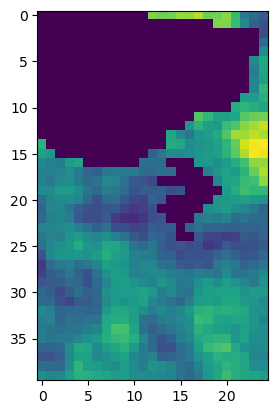

In [27]:
plt.imshow(kv3)

In [28]:
transmissitivty = k11 * thickness

In [29]:
k11[2, :, :] = kh3
k33[2, :, :] = kv3

In [30]:
k33 /= k11
kv3 = k33[2, :, :]
kv3[clay_location == 0] = 1.0
kv3[clay_location == 1] = kvkh_ratio

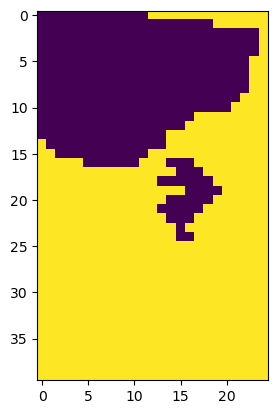

In [31]:
plt.imshow(k33[2, :, :])

In [32]:
k1 = k11[0, :, :]
k1[lake_location == 1] = 2000000.0
k11[0, :, :] = k1

In [33]:
k1 = k33[0, :, :]
k1[lake_location == 1] = 2000000.0
k33[0, :, :] = k1

In [34]:
ss = [5e-5, 5e-5, 5e-3, 5e-5, 5e-5]
v = np.full(shape2d, 5e-5, dtype=float)
v[clay_location == 1] = 5e-3
ss[2] = v


sy = [0.25, 0.25, 0.025, 0.25, 0.25]
v = np.full(shape2d, 0.25, dtype=float)
v[lake_location == 1] = 1.0
sy[0] = v

v = np.full(shape2d, 0.25, dtype=float)
v[clay_location == 1] = 0.45
sy[2] = v

## Define the recharge

In [35]:
recharge_spd = {}
for n in range(nper):
    row = temporal_df.iloc[n]
    spd = []
    for i in range(nrow):
        for j in range(ncol):
            if lake_location[i, j] == 1:
                if useET:
                    rch_ts = "PRCP (Inches)"
                    boundname = "lake"
                else:
                    rch_ts = "netrch lake (inches)"
                    boundname = "lake"
            else:
                rch_ts = "netrch land (inches)"
                boundname = "land"
            spd.append(((0, i, j), float(row[rch_ts]) * in2ft, boundname))
    recharge_spd[n] = spd

## Define the evt

In [36]:
if useET:
    nlake_cells = 0
    lake_evt_spd = {}
    evt_ts = "lake et (inches)"
    for n in range(nper):
        row = temporal_df.iloc[n]
        spd = []
        for i in range(nrow):
            for j in range(ncol):
                if lake_location[i, j] == 1:
                    spd.append(((0, i, j), -4.0, float(row[evt_ts]) * in2ft, 2.0))
        lake_evt_spd[n] = spd
    nlake_cells = len(spd)

## Define the river

In [37]:
nriv = 18
stage = np.linspace(1.75, 0.05, nriv)
stage

array([1.75, 1.65, 1.55, 1.45, 1.35, 1.25, 1.15, 1.05, 0.95, 0.85, 0.75,
       0.65, 0.55, 0.45, 0.35, 0.25, 0.15, 0.05])

In [38]:
riv_bndname = ["RIV" for i in range(nriv)]

In [39]:
river_spd = [
    (0, i + 22, 8, float(stage[i]), 1e5, float(stage[i]) - 1.0, riv_bndname[i])
    for i in range(nriv)
]
river_spd

[(0, 22, 8, 1.75, 100000.0, 0.75, 'RIV'),
 (0, 23, 8, 1.65, 100000.0, 0.6499999999999999, 'RIV'),
 (0, 24, 8, 1.55, 100000.0, 0.55, 'RIV'),
 (0, 25, 8, 1.45, 100000.0, 0.44999999999999996, 'RIV'),
 (0, 26, 8, 1.35, 100000.0, 0.3500000000000001, 'RIV'),
 (0, 27, 8, 1.25, 100000.0, 0.25, 'RIV'),
 (0, 28, 8, 1.15, 100000.0, 0.1499999999999999, 'RIV'),
 (0, 29, 8, 1.05, 100000.0, 0.050000000000000044, 'RIV'),
 (0, 30, 8, 0.9500000000000001, 100000.0, -0.04999999999999993, 'RIV'),
 (0, 31, 8, 0.8500000000000001, 100000.0, -0.1499999999999999, 'RIV'),
 (0, 32, 8, 0.7500000000000001, 100000.0, -0.2499999999999999, 'RIV'),
 (0, 33, 8, 0.6500000000000001, 100000.0, -0.34999999999999987, 'RIV'),
 (0, 34, 8, 0.55, 100000.0, -0.44999999999999996, 'RIV'),
 (0, 35, 8, 0.4500000000000002, 100000.0, -0.5499999999999998, 'RIV'),
 (0, 36, 8, 0.3500000000000001, 100000.0, -0.6499999999999999, 'RIV'),
 (0, 37, 8, 0.2500000000000002, 100000.0, -0.7499999999999998, 'RIV'),
 (0, 38, 8, 0.15000000000000013, 1

## Define the wells

In [40]:
def get_well_data(i, j, tag, k0=3, k1=4):
    T = 0.0
    T_k = []
    for k in range(k0, k1 + 1):
        value = float(transmissitivty[k, i, j])
        T += value
        T_k.append(value)
    well_data = []
    fractions = []
    idx = 0
    for k in range(k0, k1 + 1):
        well_data.append((k, i, j, f"{tag}_{k + 1}", tag))
        fractions.append(T_k[idx] / T)
        idx += 1
    return well_data, fractions

In [41]:
well_spd_base = {
    1: [
        (5, 14, "reilly"),
        (32, 5, "vc"),
    ],
}

In [42]:
well_fractions = {}
for n, values in well_spd_base.items():
    rates = []
    fractions = []
    for i, j, well_name in values:
        rate, fraction = get_well_data(i, j, well_name)
        rates += rate
        fractions += fraction
    for idx, (k, i, j, tag, well_name) in enumerate(rates):
        well_fractions[tag] = ((k, i, j), fractions[idx], well_name)

well_fractions

{'reilly_4': ((3, 5, 14), 0.5034470567438571, 'reilly'),
 'reilly_5': ((4, 5, 14), 0.4965529432561428, 'reilly'),
 'vc_4': ((3, 32, 5), 0.49997737658929453, 'vc'),
 'vc_5': ((4, 32, 5), 0.5000226234107054, 'vc')}

In [43]:
well_spd = {}
for n in range(1, nper):
    row = temporal_df.iloc[n]
    spd = []
    for key, (cellid, fraction, well_name) in well_fractions.items():
        spd.append(((cellid), float(row[well_name]) * fraction, well_name))
    well_spd[n] = spd
well_spd[1]

[((3, 5, 14), -36902.63092857209, 'reilly'),
 ((4, 5, 14), -36397.292934817066, 'reilly'),
 ((3, 32, 5), -146593.21454964936, 'vc'),
 ((4, 32, 5), -146606.48090390727, 'vc')]

## Define the well for the prediction

In [44]:
prediction_spd = {}
for n in range(idx_end_period2 + 1, nper):
    # rate = 0.0
    # if n >= idx_end_period2 + 1:
    rate = -300000.0
    prediction_spd[n] = [((4, 34, 15), rate)]

## Define the head observations

In [45]:
obs_rc_locs = [
    (2, 17),
    (3, 10),
    (6, 20),
    (12, 22),
    (14, 11),
    (16, 18),
    (17, 1),
    (18, 6),
    (19, 11),
    (18, 22),
    (26, 5),
    (27, 11),
    (28, 23),
    (30, 6),
    (33, 14),
    (36, 1),
    (37, 22),
]

In [46]:
np.array(botm)[:, 3, 10]

array([  -5.  ,  -15.  ,  -50.35, -139.35, -227.22])

In [47]:
well_depth = [
    -200.74,
    -100.00,
    -100.00,
    -100.00,
    -224.62,
    -100.00,
    -100.00,
    -100.00,
    -100.00,
    -100.00,
    -100.00,
    -100.00,
    -100.00,
    -100.00,
    -233.22,
    -100.00,
    -100.00,
]

In [48]:
wt_obs = []
aq_layer = []
aq_obs = []
for idx, (i, j) in enumerate(obs_rc_locs):
    iloc = (i, j)
    tag = "head_layer1"
    wt_obs.append(float(nc_ds[tag].values[iloc]))
    wz = well_depth[idx]
    zcell = np.array(botm)[:, i, j]
    klay = 0
    for kk in range(1, nlay):
        z0 = zcell[kk - 1]
        z1 = zcell[kk]
        if wz < z0 and wz >= z1:
            klay = kk
            break
    tag = f"head_layer{klay + 1}"
    aq_layer.append(klay)
    aq_obs.append(float(nc_ds[tag].values[iloc]))

In [49]:
obs_path = pl.Path("../data")
combined_data = [obs_rc_locs, well_depth, aq_layer]
with open(obs_path / "obs_data.pkl", "wb") as f:
    pickle.dump(combined_data, f)

In [50]:
print(wt_obs)

[13.246935444094863, 13.050041294233779, 13.40136173946405, 12.544121369301225, 12.077999268630307, 11.876444122713464, 9.895115589310995, 9.401201315406293, 9.549893705144363, 11.764203250892516, 3.921932501545215, 3.896987567754207, 8.629555697960368, 2.0975467831702272, 5.035503962366297, 2.7855189008864003, 7.2504974427425735]


In [51]:
print(aq_layer)

[4, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3]


In [52]:
print(aq_obs)

[12.884374502834035, 12.385166504301345, 12.876962524681726, 12.542174637539913, 11.407699547087939, 11.872925701796126, 9.885186148404362, 9.387484328750379, 9.535869472946963, 11.761990669357623, 3.9117703734559894, 3.8859389698058293, 8.626048130377985, 2.0822869617681103, 5.018706242307758, 2.7683383476545376, 7.2471104155116475]


In [53]:
cal_loc_wt = [(0, i, j) for i, j in obs_rc_locs]

In [54]:
cal_loc_aq = [(aq_layer[idx], i, j) for idx, (i, j) in enumerate(obs_rc_locs)]

In [55]:
obs_loc = {}
obs_loc[f"{name}.gwf.wt.csv"] = [
    (f"wt{idx + 1:02d}-i{i}-j{j}", "HEAD", (0, i, j)) for idx, (i, j) in enumerate(obs_rc_locs)
]

In [56]:
obs_loc[f"{name}.gwf.aq.csv"] = [
    (f"aq{idx + 1:02d}-i{i}-j{j}", "HEAD", (aq_layer[idx], i, j))
    for idx, (i, j) in enumerate(obs_rc_locs)
]

In [57]:
obs_loc

{'sv.gwf.wt.csv': [('wt01-i2-j17', 'HEAD', (0, 2, 17)),
  ('wt02-i3-j10', 'HEAD', (0, 3, 10)),
  ('wt03-i6-j20', 'HEAD', (0, 6, 20)),
  ('wt04-i12-j22', 'HEAD', (0, 12, 22)),
  ('wt05-i14-j11', 'HEAD', (0, 14, 11)),
  ('wt06-i16-j18', 'HEAD', (0, 16, 18)),
  ('wt07-i17-j1', 'HEAD', (0, 17, 1)),
  ('wt08-i18-j6', 'HEAD', (0, 18, 6)),
  ('wt09-i19-j11', 'HEAD', (0, 19, 11)),
  ('wt10-i18-j22', 'HEAD', (0, 18, 22)),
  ('wt11-i26-j5', 'HEAD', (0, 26, 5)),
  ('wt12-i27-j11', 'HEAD', (0, 27, 11)),
  ('wt13-i28-j23', 'HEAD', (0, 28, 23)),
  ('wt14-i30-j6', 'HEAD', (0, 30, 6)),
  ('wt15-i33-j14', 'HEAD', (0, 33, 14)),
  ('wt16-i36-j1', 'HEAD', (0, 36, 1)),
  ('wt17-i37-j22', 'HEAD', (0, 37, 22))],
 'sv.gwf.aq.csv': [('aq01-i2-j17', 'HEAD', (4, 2, 17)),
  ('aq02-i3-j10', 'HEAD', (3, 3, 10)),
  ('aq03-i6-j20', 'HEAD', (3, 6, 20)),
  ('aq04-i12-j22', 'HEAD', (3, 12, 22)),
  ('aq05-i14-j11', 'HEAD', (4, 14, 11)),
  ('aq06-i16-j18', 'HEAD', (3, 16, 18)),
  ('aq07-i17-j1', 'HEAD', (3, 17, 1)),
  ('a

In [58]:
obs_loc[f"{name}.gwf.scenario.csv"] = [
    ("Reilly", "HEAD", (4, 5, 14)),
    ("VC", "HEAD", (4, 34, 15)),
    ("DW", "HEAD", (0, 22, 19)),
]

In [59]:
obs_loc[f"{name}.lake.obs.csv"] = [
    ("Lake-stage", "HEAD", (0, 15, 8)),
]

In [60]:
obs_loc

{'sv.gwf.wt.csv': [('wt01-i2-j17', 'HEAD', (0, 2, 17)),
  ('wt02-i3-j10', 'HEAD', (0, 3, 10)),
  ('wt03-i6-j20', 'HEAD', (0, 6, 20)),
  ('wt04-i12-j22', 'HEAD', (0, 12, 22)),
  ('wt05-i14-j11', 'HEAD', (0, 14, 11)),
  ('wt06-i16-j18', 'HEAD', (0, 16, 18)),
  ('wt07-i17-j1', 'HEAD', (0, 17, 1)),
  ('wt08-i18-j6', 'HEAD', (0, 18, 6)),
  ('wt09-i19-j11', 'HEAD', (0, 19, 11)),
  ('wt10-i18-j22', 'HEAD', (0, 18, 22)),
  ('wt11-i26-j5', 'HEAD', (0, 26, 5)),
  ('wt12-i27-j11', 'HEAD', (0, 27, 11)),
  ('wt13-i28-j23', 'HEAD', (0, 28, 23)),
  ('wt14-i30-j6', 'HEAD', (0, 30, 6)),
  ('wt15-i33-j14', 'HEAD', (0, 33, 14)),
  ('wt16-i36-j1', 'HEAD', (0, 36, 1)),
  ('wt17-i37-j22', 'HEAD', (0, 37, 22))],
 'sv.gwf.aq.csv': [('aq01-i2-j17', 'HEAD', (4, 2, 17)),
  ('aq02-i3-j10', 'HEAD', (3, 3, 10)),
  ('aq03-i6-j20', 'HEAD', (3, 6, 20)),
  ('aq04-i12-j22', 'HEAD', (3, 12, 22)),
  ('aq05-i14-j11', 'HEAD', (4, 14, 11)),
  ('aq06-i16-j18', 'HEAD', (3, 16, 18)),
  ('aq07-i17-j1', 'HEAD', (3, 17, 1)),
  ('a

## Build the model

In [61]:
sim = flopy.mf6.MFSimulation(sim_name=name, sim_ws=ws, write_headers=False)

In [62]:
tdis = flopy.mf6.ModflowTdis(
    sim,
    start_date_time=start_date_time,
    time_units="DAY",
    nper=nper,
    perioddata=tdis_ds,
)

In [63]:
ims = flopy.mf6.ModflowIms(
    sim,
    print_option="summary",
    complexity="complex",
    under_relaxation=None,
    linear_acceleration="bicgstab",
    outer_maximum=5000,
    inner_maximum=100,
    outer_dvclose=1e-5,
    inner_dvclose=1e-6,
)

In [64]:
gwf = flopy.mf6.ModflowGwf(
    sim, modelname=name, save_flows=True, newtonoptions="newton under_relaxation"
)

In [65]:
dis = flopy.mf6.ModflowGwfdis(
    gwf,
    length_units="FEET",
    nlay=nlay,
    nrow=nrow,
    ncol=ncol,
    delr=delr,
    delc=delc,
    top=top,
    botm=botm,
    idomain=idomain,
)

In [66]:
ic = flopy.mf6.ModflowGwfic(gwf, strt=strt)

In [67]:
npf = flopy.mf6.ModflowGwfnpf(
    gwf, save_specific_discharge=True, k=k11, k33=k33, k33overk=True
)

In [68]:
sto = flopy.mf6.ModflowGwfsto(
    gwf,
    sy=sy,
    ss=ss,
    steady_state={0: True},
    transient={1: True},
)

In [69]:
rch = flopy.mf6.ModflowGwfrch(
    gwf,
    boundnames=True,
    maxbound=shape2d,
    stress_period_data=recharge_spd,
)

In [70]:
if useET:
    lake_evt = flopy.mf6.ModflowGwfevt(
        gwf,
        maxbound=nlake_cells,
        stress_period_data=lake_evt_spd,
    )

In [71]:
riv_obs = {f"{name}.riv.obs.csv": [("RIV-SWGW", "RIV", "RIV")]}

In [72]:
riv = flopy.mf6.ModflowGwfriv(
    gwf,
    boundnames=True,
    print_flows=True,
    maxbound=nriv,
    stress_period_data=river_spd,
    observations=riv_obs,
    pname="riv-1",
)

In [73]:
wel = flopy.mf6.ModflowGwfwel(
    gwf,
    boundnames=True,
    filename=f"{name}.pwell.wel",
    stress_period_data=well_spd,
    maxbound=4,
    pname="pwell",
)

In [74]:
pred_well = flopy.mf6.ModflowGwfwel(
    gwf,
    filename=f"{name}.prediction.well",
    maxbound=1,
    stress_period_data=prediction_spd,
    pname="prediction",
)

In [75]:
oc = flopy.mf6.ModflowGwfoc(
    gwf,
    head_filerecord=f"{name}.hds",
    budget_filerecord=f"{name}.cbc",
    budgetcsv_filerecord=f"{name}-budget.csv",
    saverecord=[("HEAD", "ALL"), ("BUDGET", "ALL")],
)

In [76]:
gwf_obs = flopy.mf6.ModflowUtlobs(
    gwf,
    print_input=True,
    continuous=obs_loc,
    pname="gwf-obs",
    filename=f"{name}.gwf.obs",
)

In [77]:
gwf.set_all_data_external(external_data_folder="external")

sim.write_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims_-1...
  writing model sv...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package npf...
    writing package sto...
    writing package rch_0...
INFORMATION: maxbound in ('gwf6', 'rch', 'dimensions') changed to 1000 based on size of stress_period_data
    writing package evt_0...
    writing package riv-1...
    writing package obs_0...
    writing package pwell...
    writing package prediction...
    writing package oc...
    writing package gwf-obs...


In [78]:
success = sim.run_simulation()
assert success, "Model did not terminate normally"

FloPy is using the following executable to run the model: ../../../../../miniforge3/envs/tampa26mf6pp/bin/mf6
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                  VERSION 6.7.0.dev3 (preliminary) 01/14/2026
                               ***DEVELOP MODE***

        MODFLOW 6 compiled Jan 14 2026 13:48:00 with GCC version 13.4.0

This software is preliminary or provisional and is subject to 
revision. It is being provided to meet the need for timely best 
science. The software has not received final approval by the U.S. 
Geological Survey (USGS). No warranty, expressed or implied, is made 
by the USGS or the U.S. Government as to the functionality of the 
software and related material nor shall the fact of release 
constitute any such warranty. The software is provided on the 
condition that neither the USGS nor the U.S. Government shall be held 
liable for any damages resulting from the authorized or unauthorized

## Plot the results

### Model Properties

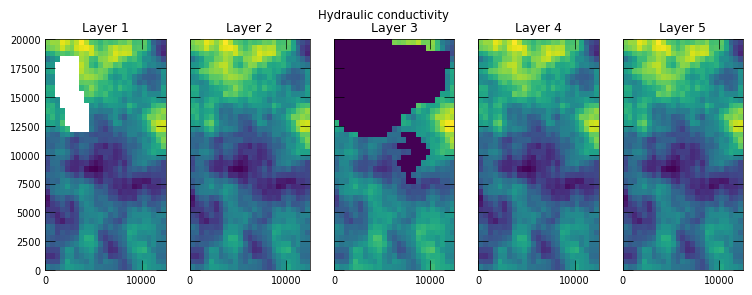

In [79]:
with flopy.plot.styles.USGSMap():
    fig, axs = plt.subplots(1, 5, figsize=(9, 3), sharey=True)
    fig.suptitle("Hydraulic conductivity")

    for idx in range(nlay):
        ax = axs[idx]
        mm = flopy.plot.PlotMapView(model=gwf, layer=idx, ax=ax)
        mm.plot_array(k11[idx], masked_values=[2000000.0])
        ax.set_title(f"Layer {idx + 1}")

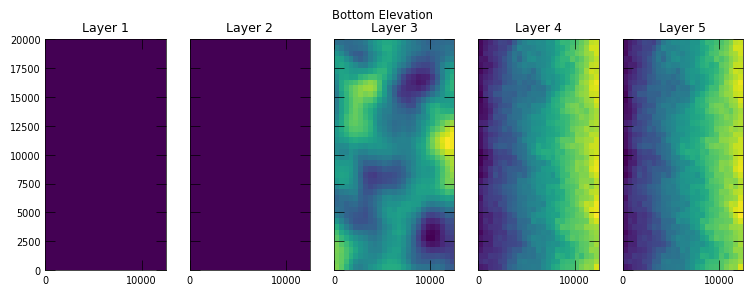

In [80]:
with flopy.plot.styles.USGSMap():
    fig, axs = plt.subplots(1, 5, figsize=(9, 3), sharey=True)
    fig.suptitle("Bottom Elevation")

    for idx in range(nlay):
        ax = axs[idx]
        mm = flopy.plot.PlotMapView(model=gwf, layer=idx, ax=ax)
        mm.plot_array(botm[idx])
        ax.set_title(f"Layer {idx + 1}")

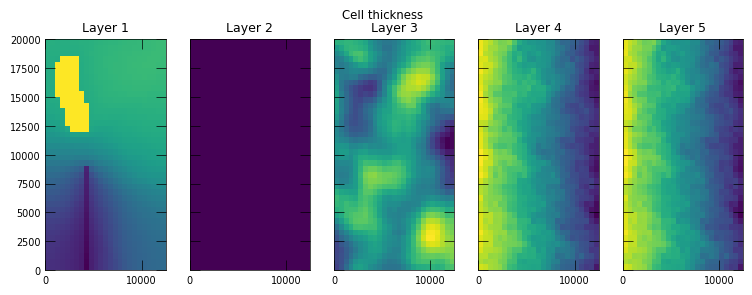

In [81]:
with flopy.plot.styles.USGSMap():
    fig, axs = plt.subplots(1, 5, figsize=(9, 3), sharey=True)
    fig.suptitle("Cell thickness")
    z = gwf.modelgrid.cell_thickness

    for idx in range(nlay):
        ax = axs[idx]
        mm = flopy.plot.PlotMapView(model=gwf, layer=idx, ax=ax)
        mm.plot_array(z[idx])
        ax.set_title(f"Layer {idx + 1}")

### Simulated Heads and Drawdown

In [82]:
levels = np.arange(2, 20.0, 2)

#### Calibration

In [83]:
hds = gwf.output.head().get_data(totim=totim_end[0])

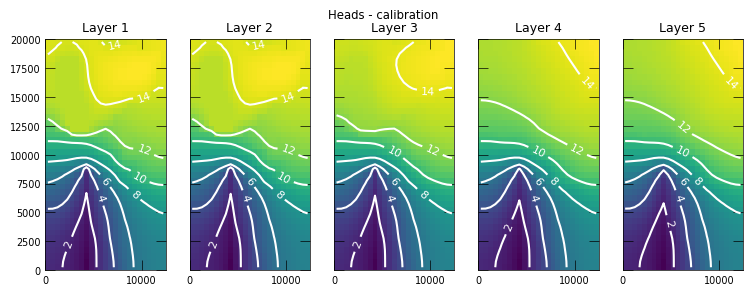

In [84]:
with flopy.plot.styles.USGSMap():
    fig, axs = plt.subplots(1, 5, figsize=(9, 3), sharey=True)
    fig.suptitle("Heads - calibration")

    for idx in range(nlay):
        ax = axs[idx]
        mm = flopy.plot.PlotMapView(model=gwf, layer=idx, ax=ax)
        mm.plot_array(hds)
        cs = mm.contour_array(hds, colors="white", levels=levels)
        plt.clabel(cs, inline=True, fontsize=8)
        ax.set_title(f"Layer {idx + 1}")

In [85]:
v = gwf.output.budget().get_data(text="riv", totim=totim_end[0])[0]["q"]
print(f"River infiltration: {np.all(v > 0)}\n{v}")

River infiltration: False
[-93716.17082039 -69145.91564984 -72370.87124069 -73368.03591172
 -67401.93383382 -60207.30489554 -55600.35495436 -51369.46630329
 -48191.60056868 -45831.97909681 -46109.6542861  -45924.02032033
 -48416.97613575 -48397.39762293 -47328.16299564 -46892.2018906
 -47155.42894126 -52666.62183896]


##### Calculate the residuals

In [86]:
sim_wt = np.array([hds[idx] for idx in cal_loc_wt])

In [87]:
resid_wt = sim_wt - np.array(wt_obs)
resid_wt

array([ 1.29589468,  1.30328459,  1.41972678,  0.86444726,  0.90624981,
        0.66522418,  0.19764942,  0.23069155,  0.20176261,  0.61156983,
        0.07443559,  0.10780726, -0.18536675,  0.23896836, -0.30553111,
       -0.33721254, -0.44939724])

In [88]:
sim_aq = np.array([hds[idx] for idx in cal_loc_aq])

In [89]:
resid_aq = sim_aq - np.array(aq_obs)
resid_aq

array([ 1.05905548,  0.85556614,  1.04199082,  0.86416413,  0.59953427,
        0.66494815,  0.20155362,  0.2366376 ,  0.20736945,  0.61118833,
        0.07994075,  0.11358448, -0.18539527,  0.2473985 , -0.29670678,
       -0.32777038, -0.44920801])

In [90]:
resid_gb = np.concatenate((resid_wt, resid_aq))

In [91]:
print(
    f"Water Table Statistics\nMean Error: {resid_wt.mean()} ft.\nRMSE:       {np.sqrt((resid_wt**2).sum()) / resid_wt.shape[0]} ft."
)

Water Table Statistics
Mean Error: 0.4023649588970974 ft.
RMSE:       0.17078343569352109 ft.


In [92]:
print(
    f"Lower Aquifer Statistics\nMean Error: {resid_aq.mean()} ft.\nRMSE:       {np.sqrt((resid_aq**2).sum()) / resid_aq.shape[0]} ft."
)

Lower Aquifer Statistics
Mean Error: 0.3249324277893046 ft.
RMSE:       0.1381165177127848 ft.


In [93]:
print(
    f"Global Statistics\nMean Error: {resid_gb.mean()} ft.\nRMSE:       {np.sqrt((resid_gb**2).sum()) / resid_gb.shape[0]} ft."
)

Global Statistics
Mean Error: 0.36364869334320093 ft.
RMSE:       0.10982162170127184 ft.


##### Plot the residuals

In [94]:
xy = [
    (float(gwf.modelgrid.xcellcenters[i, j]), float(gwf.modelgrid.ycellcenters[i, j]))
    for i, j in obs_rc_locs
]

In [95]:
x, y = np.array(xy)[:, 0], np.array(xy)[:, 1]

In [96]:
grid_x, grid_y = np.meshgrid(gwf.modelgrid.xycenters[0], gwf.modelgrid.xycenters[1])

In [97]:
# Linearly interpolate the data (x, y) on a grid defined by (xi, yi).
triang = tri.Triangulation(x, y)

In [98]:
interpolator = tri.LinearTriInterpolator(triang, resid_wt)
grid_resid_wt = interpolator(grid_x, grid_y)

In [99]:
interpolator = tri.LinearTriInterpolator(triang, resid_aq)
grid_resid_aq = interpolator(grid_x, grid_y)

In [100]:
resid_levels = np.arange(-2, 2.25, 0.25)

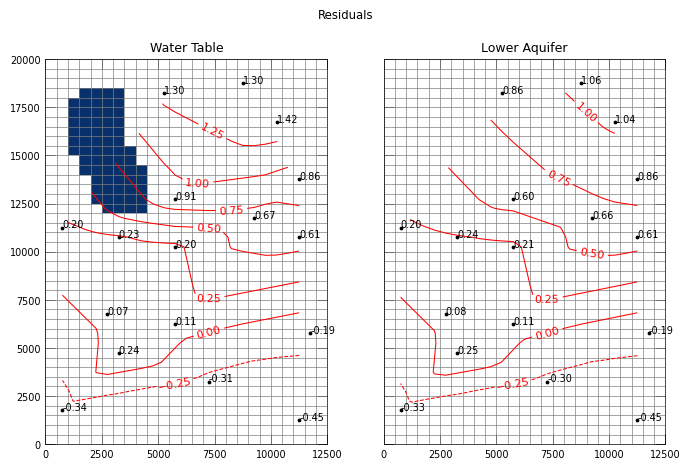

In [101]:
with flopy.plot.styles.USGSMap():
    fig, axs = plt.subplots(1, 2, figsize=(8, 5), sharey=True)
    fig.suptitle("Residuals")

    ax = axs[0]
    ax.set_xlim(0, 12500)
    ax.set_ylim(0, 20000)
    mm = flopy.plot.PlotMapView(model=gwf, ax=ax, extent=gwf.modelgrid.extent)
    mm.plot_array(lake_location, cmap="Blues_r", masked_values=[0])
    mm.plot_grid(lw=0.5, color="0.5")
    ax.scatter(x, y, s=3, c="black")
    for i, txt in enumerate(resid_wt):
        ax.annotate(f"{txt:.2f}", (x[i], y[i]))
    cs = ax.contour(
        grid_x,
        grid_y,
        grid_resid_wt,
        levels=resid_levels,
        linewidths=0.75,
        colors="red",
    )
    plt.clabel(cs, inline=True, fontsize=8)
    ax.set_title("Water Table")

    ax = axs[1]
    ax.set_xlim(0, 12500)
    ax.set_ylim(0, 20000)
    mm = flopy.plot.PlotMapView(model=gwf, ax=ax, extent=gwf.modelgrid.extent)
    mm.plot_grid(lw=0.5, color="0.5")
    ax.scatter(x, y, s=3, c="black")
    for i, txt in enumerate(resid_aq):
        ax.annotate(f"{txt:.2f}", (x[i], y[i]), clip_on=False)
    cs = ax.contour(
        grid_x,
        grid_y,
        grid_resid_aq,
        levels=resid_levels,
        linewidths=0.75,
        colors="red",
    )
    plt.clabel(cs, inline=True, fontsize=8)
    ax.set_title("Lower Aquifer")

**NOTE:** There is spatial bias in the simulated results (*i.e.*, residuals are positive in the Northeast and negative in the Southwest).

#### Case A

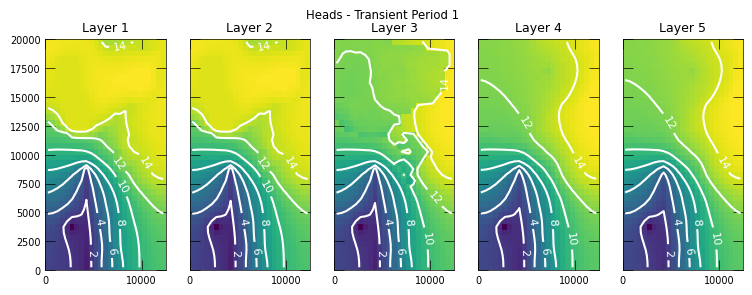

In [102]:
with flopy.plot.styles.USGSMap():
    fig, axs = plt.subplots(1, 5, figsize=(9, 3), sharey=True)
    fig.suptitle("Heads - Transient Period 1")
    hds = gwf.output.head().get_data(totim=totim_end[1])

    for idx in range(nlay):
        ax = axs[idx]
        mm = flopy.plot.PlotMapView(model=gwf, layer=idx, ax=ax)
        mm.plot_array(hds)
        cs = mm.contour_array(hds, colors="white", levels=levels)
        plt.clabel(cs, inline=True, fontsize=8)
        ax.set_title(f"Layer {idx + 1}")

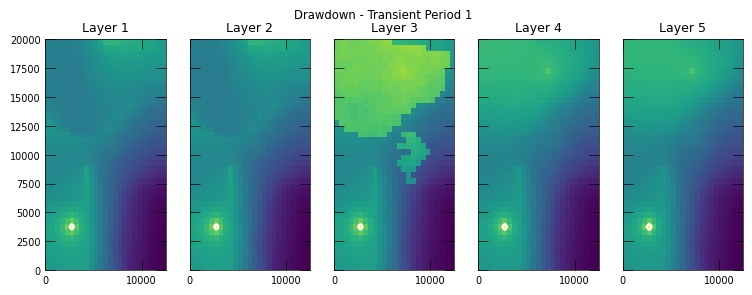

In [103]:
with flopy.plot.styles.USGSMap():
    fig, axs = plt.subplots(1, 5, figsize=(9, 3), sharey=True)
    fig.suptitle("Drawdown - Transient Period 1")
    ddn = gwf.output.head().get_data(totim=totim_end[0]) - gwf.output.head().get_data(
        totim=totim_end[1]
    )

    ddn_max = ddn[:, 16, :].max()

    for idx in range(nlay):
        ax = axs[idx]
        mm = flopy.plot.PlotMapView(model=gwf, layer=idx, ax=ax)
        mm.plot_array(ddn)
        cs = mm.contour_array(ddn, colors="white", levels=levels)
        plt.clabel(cs, inline=True, fontsize=8)
        ax.set_title(f"Layer {idx + 1}")

In [104]:
print(f"Maximum Drawdown: {ddn_max}")

Maximum Drawdown: 0.7817234418858057


In [105]:
v = gwf.output.budget().get_data(text="riv", totim=totim_end[1])[0]["q"]
print(f"Induced river infiltration: {np.all(v > 0)}\n{v}")

Induced river infiltration: False
[-113071.78932958  -87058.85738923  -93594.8265084   -96355.91812927
  -89312.16678825  -80205.81976824  -73827.11925863  -66913.43184316
  -60032.19931767  -53929.26653288  -52159.30978144  -53388.40168327
  -59549.36384408  -62383.32296984  -63293.8811933   -64200.58246594
  -65065.08937575  -71807.16831162]


#### Extra Run

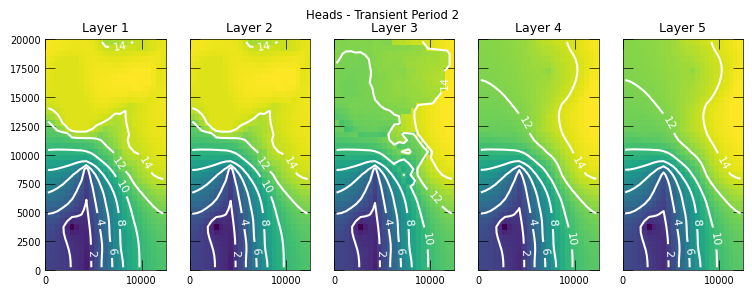

In [106]:
with flopy.plot.styles.USGSMap():
    fig, axs = plt.subplots(1, 5, figsize=(9, 3), sharey=True)
    fig.suptitle("Heads - Transient Period 2")
    hds = gwf.output.head().get_data(totim=totim_end[2])

    for idx in range(nlay):
        ax = axs[idx]
        mm = flopy.plot.PlotMapView(model=gwf, layer=idx, ax=ax)
        mm.plot_array(hds)
        cs = mm.contour_array(hds, colors="white", levels=levels)
        plt.clabel(cs, inline=True, fontsize=8)
        ax.set_title(f"Layer {idx + 1}")

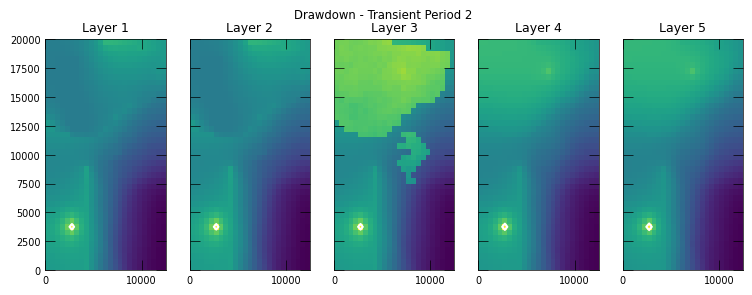

In [107]:
with flopy.plot.styles.USGSMap():
    fig, axs = plt.subplots(1, 5, figsize=(9, 3), sharey=True)
    fig.suptitle("Drawdown - Transient Period 2")
    ddn = gwf.output.head().get_data(totim=totim_end[0]) - gwf.output.head().get_data(
        totim=totim_end[2]
    )

    ddn_max = ddn[:, 16, :].max()

    for idx in range(nlay):
        ax = axs[idx]
        mm = flopy.plot.PlotMapView(model=gwf, layer=idx, ax=ax)
        mm.plot_array(ddn)
        cs = mm.contour_array(ddn, colors="white", levels=levels)
        plt.clabel(cs, inline=True, fontsize=8)
        ax.set_title(f"Layer {idx + 1}")

In [108]:
print(f"Maximum Drawdown: {ddn_max}")

Maximum Drawdown: 0.7817234418858057


In [109]:
v = gwf.output.budget().get_data(text="riv", totim=totim_end[2])[0]["q"]
print(f"Induced river infiltration: {np.all(v > 0)}\n{v}")

Induced river infiltration: False
[-113071.78932958  -87058.85738923  -93594.8265084   -96355.91812927
  -89312.16678825  -80205.81976824  -73827.11925863  -66913.43184316
  -60032.19931767  -53929.26653288  -52159.30978144  -53388.40168327
  -59549.36384408  -62383.32296984  -63293.8811933   -64200.58246594
  -65065.08937575  -71807.16831162]


### Streamflow results

In [110]:
df = riv.output.obs().get_dataframe(start_datetime=start_date_time)
df["RIV-SWGW"] /= -86400
df["TOTAL"] = df["RIV-SWGW"]
Q0 = df["TOTAL"].iloc[0]
df["PCT_DIFF"] = -100.0 * (df["TOTAL"] - Q0) / Q0
df

,totim,RIV-SWGW,TOTAL,PCT_DIFF
2006-01-01,16071.0,11.806645,11.806645,-0.000000
2006-02-01,16102.0,11.433546,11.433546,3.160074
2006-03-01,16130.0,12.192501,12.192501,-3.268130
2006-04-01,16161.0,2.413989,2.413989,79.553978
2006-05-01,16191.0,12.726988,12.726988,-7.795127
...,...,...,...,...
2025-09-01,23254.0,-3.406822,-3.406822,128.855128
2025-10-01,23284.0,-0.280835,-0.280835,102.378617
2025-11-01,23315.0,4.902894,4.902894,58.473433
2025-12-01,23345.0,1.976745,1.976745,83.257348


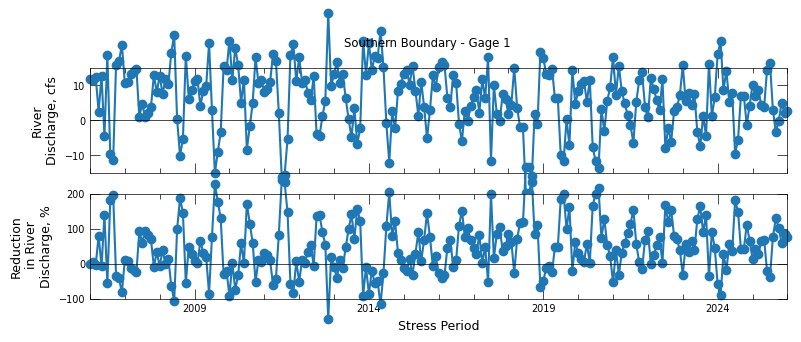

In [111]:
with flopy.plot.styles.USGSPlot():
    fig, axs = plt.subplots(2, 1, figsize=(9, 3), sharex=True)

    fig.suptitle("Southern Boundary - Gage 1")

    ax = axs[0]
    ax.set_ylim(-15, 15)
    df["TOTAL"].plot(ax=ax, ls="-", marker="o", clip_on=False)
    ax.axhline(0, lw=0.5, color="black")
    ax.set_ylabel("River\nDischarge, cfs")

    ax = axs[1]
    ax.set_ylim(-100, 200)
    df["PCT_DIFF"].plot(ax=ax, ls="-", marker="o", clip_on=False)
    ax.axhline(0, lw=0.5, color="black")
    ax.set_ylabel("Reduction\n in River\nDischarge, %")
    ax.set_xlabel("Stress Period")

### Lake stage

In [112]:
fpth = ws / f"{name}.lake.obs.csv"

In [113]:
lak_df = flopy.utils.Mf6Obs(fpth).get_dataframe(start_datetime=start_date_time)
lak_df

,totim,LAKE-STAGE
2006-01-01,16071.0,13.415947
2006-02-01,16102.0,14.743659
2006-03-01,16130.0,15.280765
2006-04-01,16161.0,11.325234
2006-05-01,16191.0,14.864955
...,...,...
2025-09-01,23254.0,9.491150
2025-10-01,23284.0,10.166435
2025-11-01,23315.0,11.830959
2025-12-01,23345.0,10.611857


In [114]:
lak_df["LAKE-STAGE"].min()

np.float64(-5.470841659116556)

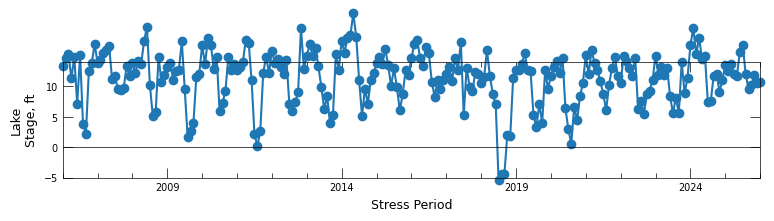

In [115]:
with flopy.plot.styles.USGSPlot():
    fig, ax = plt.subplots(1, 1, figsize=(9, 1.5))

    lak_df["LAKE-STAGE"].plot(
        ax=ax,
        ls="-",
        marker="o",
        clip_on=False,
    )
    ax.axhline(0, lw=0.5, color="black")
    ax.set_ylabel("Lake\nStage, ft")
    ax.set_xlabel("Stress Period")
    ax.set_ylim(-5, 14)

In [116]:
ws = pl.Path(f"../../models/synthetic-valley-working-{sample_frequency}")

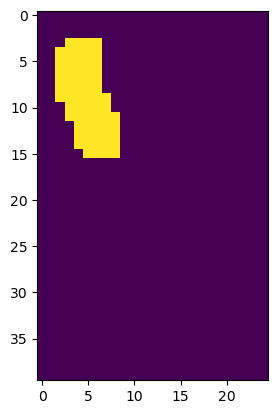

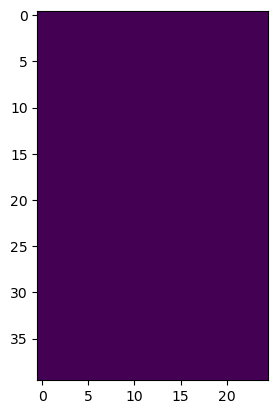

In [117]:
sim.set_sim_path(ws)
gwf = sim.get_model()
array = gwf.npf.k.array.copy()
# print(array[0,:,:].max())
# plt.imshow(array[0,:,:])
# plt.show()
for k in range(array.shape[0]):
    if k == 0:
        mx = array[k, :, :].max()
        mask = array[k, :, :] == mx
        # print(mx)
        # print(mask)

    # if k == 2:
    #    mn = array[k, :, :].min()
    #    mx = array[k, :, :].max()
    #    array[k, :, :] = mx
    #    array[k, : int(array.shape[1] / 4), :] = mn
    # else:
    array[k, :, :] = 10 ** (np.log10(array[k, :, :]).mean())
    if k == 0:
        arr = array[k, :, :]
        arr[mask] = mx
        array[k, :, :] = arr

gwf.npf.k = array
plt.imshow(gwf.npf.k.array[0, :, :])
plt.show()

array = gwf.npf.k33.array.copy()
# plt.imshow(array[2,:,:])
for k in range(array.shape[0]):
    # if k == 2:
    #    mn = array[k, :, :].min()
    #    mx = array[k, :, :].max()
    #    array[k, :, :] = mx
    #    print(mn,mx)
    #    array[k, : int(array.shape[1] / 3), :int(array.shape[1] / 3)] = mn
    # else:
    array[k, :, :] = 10 ** (np.log10(array[k, :, :]).mean())
plt.imshow(array[2, :, :])
gwf.npf.k33 = array

In [118]:
sim.write_simulation()
sim.run_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims_-1...
  writing model sv...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package npf...
    writing package sto...
    writing package rch_0...
    writing package evt_0...
    writing package riv-1...
    writing package obs_0...
    writing package pwell...
    writing package prediction...
    writing package oc...
    writing package gwf-obs...
FloPy is using the following executable to run the model: ../../../../../miniforge3/envs/tampa26mf6pp/bin/mf6
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                  VERSION 6.7.0.dev3 (preliminary) 01/14/2026
                               ***DEVELOP MODE***

        MODFLOW 6 compiled Jan 14 2026 13:48:00 with GCC version 13.4.0

This software is preliminary or provisional and is subject to 
revisi

(True, [])